# Going Deeper(Resnet)
## ResNet 구조를 만들어보고 ResNet-34 모델과 ResNet-50 모델의 성능을 비교해보자.
### cats_vs_dog 데이터 준비하기

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model

In [2]:
!pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
BATCH_SIZE = 32
EPOCH = 10

In [55]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [56]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [57]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [58]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [59]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [60]:
ds_info.features["label"].names

['cat', 'dog']

In [61]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

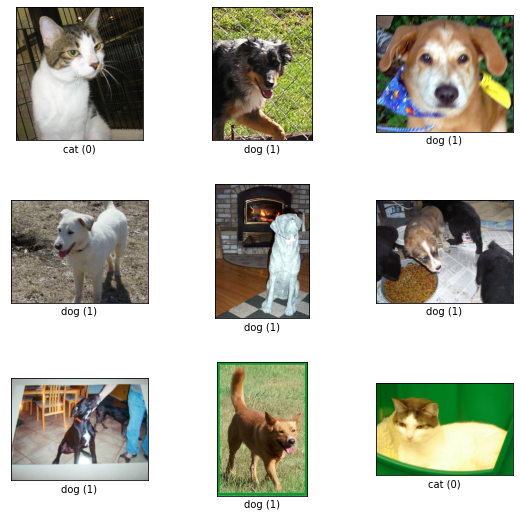

In [62]:
fig = tfds.show_examples(ds_train, ds_info)

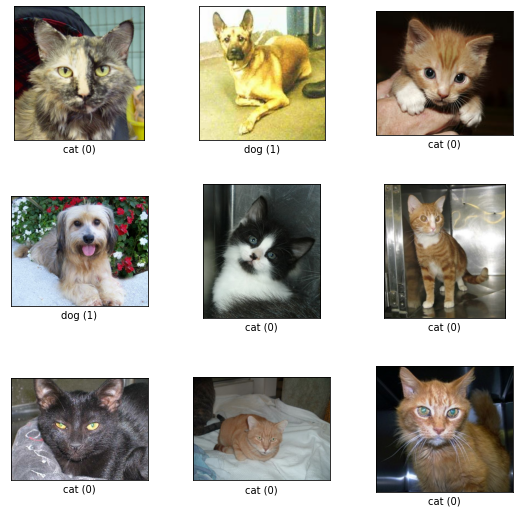

In [63]:
fig = tfds.show_examples(ds_test, ds_info)

In [64]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### ResNet34-plain 모델 구성

In [92]:
def resnet34_plain(input,num):
  def linear1(x,kernel_size,filter):

   

    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x
  
  def linear2(x,kernel_size, filter,filter2):
    
   
  
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=2,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x
  
  x = input
    
  x = tf.keras.layers.Conv2D(kernel_size=(7,7),filters=64,strides=2,padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D((3,3),strides=2,padding='same')(x)
    
  
  for i in range(3):
    x = linear1(x,(3,3),64)
    
  x = linear2(x,(3,3),128,128)
  for i in range(3):
    x = linear1(x,(3,3),128)

  x = linear2(x,(3,3),256,256)
  for i in range(5):
    x = linear1(x,(3,3),256)

  x = linear2(x,(3,3),512,512)
  for i in range(2):
    x = linear1(x,(3,3),512)
  
  x = tf.keras.layers.AveragePooling2D(padding='same')(x)
  x = tf.keras.layers.Flatten(name = 'flatten')(x)
  x = tf.keras.layers.Dense(num,activation='softmax',name = 'fc1')(x)
  
    
  return x

In [93]:
resnet_input_layer = tf.keras.layers.Input(shape=(224,224,3))

In [94]:
resnet34_plain_block_output = resnet34_plain(resnet_input_layer,2)

In [95]:
model_resnet34_plain = tf.keras.Model(inputs=resnet_input_layer, outputs=resnet34_plain_block_output)  

model_resnet34_plain.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_206 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_197 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_197 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_207 (Conv2D)         (None, 56, 56, 64)        3692

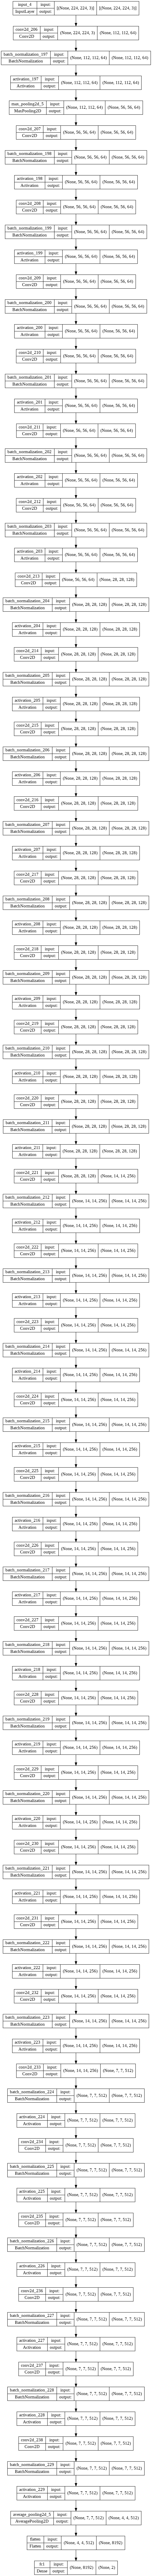

In [96]:
plot_model(model_resnet34_plain, to_file = 'a.png', show_shapes = True)

### resnet50_plain 모델 구성

In [113]:
def resnet50_plain(input,num):
  def linear1(x,kernel_size,kernel_size2,filter,filter2):
    
    
    
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=2,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size2, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter2, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x
  
  def linear2(x,kernel_size,kernel_size2,filter,filter2):
    
    
    
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size2, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter2, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

  def linear3(x,kernel_size,kernel_size2,filter,filter2):
    
  
    
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size2, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter2, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x    
  
  x = input
    
  x = tf.keras.layers.Conv2D(kernel_size=(7,7),filters=64,strides=2,padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D((3,3),strides=2,padding='same')(x)

    
  for i in range(3):
    x = linear2(x,(1,1),(3,3),64,256)

  x = linear1(x,(1,1),(3,3),128,512) 
  for i in range(3):
    x = linear3(x,(1,1),(3,3),128,512) 

  x = linear1(x,(1,1),(3,3),256,1024)
  for i in range(5):
    x = linear3(x,(1,1),(3,3),256,1024)

  x = linear1(x,(1,1),(3,3),512,2048)
  for i in range(2):
    x = linear3(x,(1,1),(3,3),512,2048)
  
  x = tf.keras.layers.AveragePooling2D(padding='same')(x)
  x = tf.keras.layers.Flatten(name = 'flatten')(x)
  x = tf.keras.layers.Dense(num,activation='softmax',name = 'fc1')(x)
  
    
  return x

In [114]:
resnet50_plain_block_output = resnet50_plain(resnet_input_layer,2)

In [115]:
model_resnet50_plain = tf.keras.Model(inputs=resnet_input_layer, outputs=resnet50_plain_block_output)  

model_resnet50_plain.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_428 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_410 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_410 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_429 (Conv2D)         (None, 56, 56, 64)        416

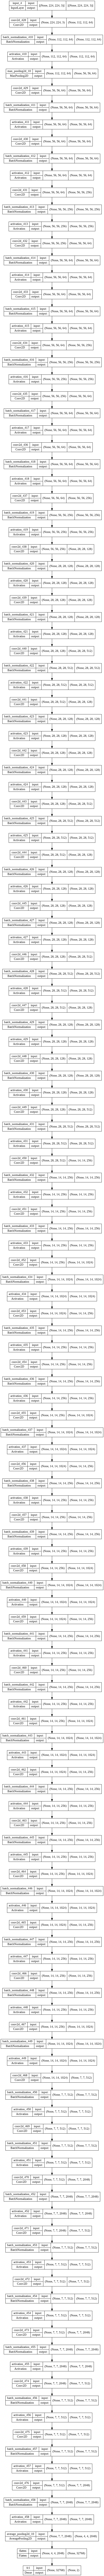

In [116]:
plot_model(model_resnet50_plain, to_file = 'a.png', show_shapes = True)

### ResNet34-residual 모델 구성

In [101]:
def resnet34(input,num):
  def linear1(x,kernel_size,filter):
    short =x

    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([short,x])
    x = tf.keras.layers.Activation('relu')(x)
    return x
  
  def linear2(x,kernel_size, filter,filter2):
    
    short = x
    short = tf.keras.layers.Conv2D(filters=filter2, kernel_size=(1, 1), strides=2, padding="same")(short) 
  
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=2,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([short,x])
    x = tf.keras.layers.Activation('relu')(x)
    return x
  
  x = input
    
  x = tf.keras.layers.Conv2D(kernel_size=(7,7),filters=64,strides=2,padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D((3,3),strides=2,padding='same')(x)
    
  
  for i in range(3):
    x = linear1(x,(3,3),64)
    
  x = linear2(x,(3,3),128,128)
  for i in range(3):
    x = linear1(x,(3,3),128)

  x = linear2(x,(3,3),256,256)
  for i in range(5):
    x = linear1(x,(3,3),256)

  x = linear2(x,(3,3),512,512)
  for i in range(2):
    x = linear1(x,(3,3),512)
  
  x = tf.keras.layers.AveragePooling2D(padding='same')(x)
  x = tf.keras.layers.Flatten(name = 'flatten')(x)
  x = tf.keras.layers.Dense(num,activation='softmax',name = 'fc1')(x)
  
    
  return x

In [106]:
resnet_block_output = resnet34(resnet_input_layer,2)

In [107]:
model_resnet34 = tf.keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model_resnet34.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_337 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_328 (Batch  (None, 112, 112, 64  256        ['conv2d_337[0][0]']             
 Normalization)                 )                                                          

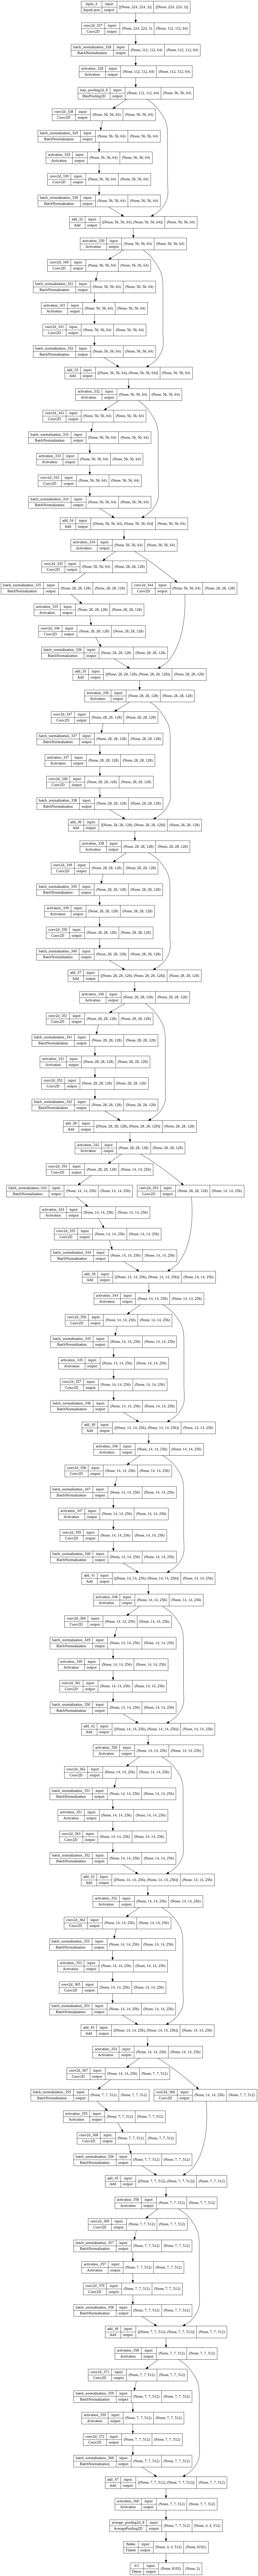

In [108]:
plot_model(model_resnet34, to_file = 'a.png', show_shapes = True)

### ResNet50_resiual 모델 구성

In [109]:
def resnet50(input,num):
  def linear1(x,kernel_size,kernel_size2,filter,filter2):
    
    short = x
    short = tf.keras.layers.Conv2D(filters=filter2, kernel_size=(1, 1), strides=2, padding="same")(short) 
    
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=2,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size2, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter2, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([short,x])
    x = tf.keras.layers.Activation('relu')(x)
    return x
  
  def linear2(x,kernel_size,kernel_size2,filter,filter2):
    
    short = x
    short = tf.keras.layers.Conv2D(filters=filter2, kernel_size=(1, 1), strides=1, padding="same")(short) 
    
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size2, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter2, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([short,x])
    x = tf.keras.layers.Activation('relu')(x)
    return x

  def linear3(x,kernel_size,kernel_size2,filter,filter2):
    
    short = x 
    
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size2, filters=filter, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=filter2, strides=1,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([short,x])
    x = tf.keras.layers.Activation('relu')(x)
    return x    
  
  x = input
    
  x = tf.keras.layers.Conv2D(kernel_size=(7,7),filters=64,strides=2,padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPool2D((3,3),strides=2,padding='same')(x)

    
  for i in range(3):
    x = linear2(x,(1,1),(3,3),64,256)

  x = linear1(x,(1,1),(3,3),128,512) 
  for i in range(3):
    x = linear3(x,(1,1),(3,3),128,512) 

  x = linear1(x,(1,1),(3,3),256,1024)
  for i in range(5):
    x = linear3(x,(1,1),(3,3),256,1024)

  x = linear1(x,(1,1),(3,3),512,2048)
  for i in range(2):
    x = linear3(x,(1,1),(3,3),512,2048)
  
  x = tf.keras.layers.AveragePooling2D(padding='same')(x)
  x = tf.keras.layers.Flatten(name = 'flatten')(x)
  x = tf.keras.layers.Dense(num,activation='softmax',name = 'fc1')(x)
  
    
  return x

In [110]:
resnet_block_50_output = resnet50(resnet_input_layer,2)

In [111]:
model_resnet50 = tf.keras.Model(inputs=resnet_input_layer, outputs=resnet_block_50_output)  

model_resnet50.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_373 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_361 (Batch  (None, 112, 112, 64  256        ['conv2d_373[0][0]']             
 Normalization)                 )                                                          

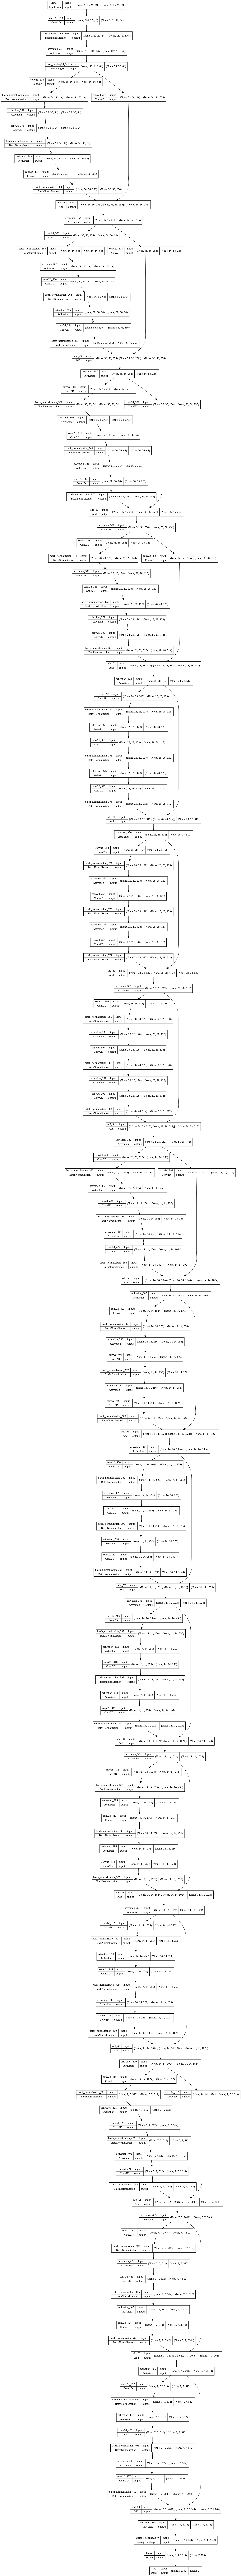

In [112]:
plot_model(model_resnet50, to_file = 'a.png', show_shapes = True)

### 모델 학습

In [117]:
model_resnet34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet34_plain = model_resnet34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 119s 185ms/step - loss: 0.7489 - accuracy: 0.5175 - val_loss: 0.7210 - val_accuracy: 0.5255
Epoch 2/10
581/581 [==============================] - 110s 189ms/step - loss: 0.7386 - accuracy: 0.5340 - val_loss: 1.1193 - val_accuracy: 0.5190
Epoch 3/10
581/581 [==============================] - 111s 191ms/step - loss: 0.7354 - accuracy: 0.5254 - val_loss: 1.3944 - val_accuracy: 0.4925
Epoch 4/10
581/581 [==============================] - 111s 191ms/step - loss: 0.7338 - accuracy: 0.5349 - val_loss: 0.9574 - val_accuracy: 0.5379
Epoch 5/10
581/581 [==============================] - 111s 192ms/step - loss: 0.7044 - accuracy: 0.5826 - val_loss: 0.8048 - val_accuracy: 0.6041
Epoch 6/10
581/581 [==============================] - 111s 191ms/step - loss: 0.6689 - accuracy: 0.6271 - val_loss: 0.6227 - val_accuracy: 0.6491
Epoch 7/10
581/581 [==============================] - 111s 192ms/step - loss: 0.6369 - accuracy: 0.6587 - val_loss: 0.6978 - val_accura

In [118]:
model_resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = model_resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 126s 196ms/step - loss: 0.9269 - accuracy: 0.5966 - val_loss: 0.7929 - val_accuracy: 0.6050
Epoch 2/10
581/581 [==============================] - 115s 198ms/step - loss: 0.7647 - accuracy: 0.6540 - val_loss: 0.7952 - val_accuracy: 0.6381
Epoch 3/10
581/581 [==============================] - 116s 199ms/step - loss: 0.6563 - accuracy: 0.7003 - val_loss: 0.6489 - val_accuracy: 0.6840
Epoch 4/10
581/581 [==============================] - 116s 200ms/step - loss: 0.5481 - accuracy: 0.7458 - val_loss: 0.7021 - val_accuracy: 0.6749
Epoch 5/10
581/581 [==============================] - 116s 200ms/step - loss: 0.4569 - accuracy: 0.7916 - val_loss: 1.0219 - val_accuracy: 0.6440
Epoch 6/10
581/581 [==============================] - 116s 199ms/step - loss: 0.3682 - accuracy: 0.8375 - val_loss: 0.6079 - val_accuracy: 0.7446
Epoch 7/10
581/581 [==============================] - 116s 200ms/step - loss: 0.2815 - accuracy: 0.8818 - val_loss: 0.5227 - val_accura

In [119]:
model_resnet50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet50_plain = model_resnet50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 186s 294ms/step - loss: 0.7609 - accuracy: 0.5276 - val_loss: 0.7782 - val_accuracy: 0.4935
Epoch 2/10
581/581 [==============================] - 174s 300ms/step - loss: 0.7664 - accuracy: 0.5162 - val_loss: 1.8192 - val_accuracy: 0.5299
Epoch 3/10
581/581 [==============================] - 174s 299ms/step - loss: 0.7662 - accuracy: 0.5137 - val_loss: 2.7708 - val_accuracy: 0.5284
Epoch 4/10
581/581 [==============================] - 173s 298ms/step - loss: 0.7700 - accuracy: 0.5118 - val_loss: 2.2786 - val_accuracy: 0.5034
Epoch 5/10
581/581 [==============================] - 173s 298ms/step - loss: 0.7686 - accuracy: 0.5173 - val_loss: 1.0350 - val_accuracy: 0.5015
Epoch 6/10
581/581 [==============================] - 174s 299ms/step - loss: 0.7707 - accuracy: 0.5102 - val_loss: 1.1601 - val_accuracy: 0.5162
Epoch 7/10
581/581 [==============================] - 174s 300ms/step - loss: 0.7638 - accuracy: 0.5211 - val_loss: 0.7933 - val_accura

In [120]:
model_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = model_resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 237s 381ms/step - loss: 1.1329 - accuracy: 0.5279 - val_loss: 5.2176 - val_accuracy: 0.5126
Epoch 2/10
581/581 [==============================] - 220s 379ms/step - loss: 1.0367 - accuracy: 0.5431 - val_loss: 6.6432 - val_accuracy: 0.5316
Epoch 3/10
581/581 [==============================] - 220s 379ms/step - loss: 0.9481 - accuracy: 0.5623 - val_loss: 4.4611 - val_accuracy: 0.4954
Epoch 4/10
581/581 [==============================] - 220s 379ms/step - loss: 0.9011 - accuracy: 0.5837 - val_loss: 0.9824 - val_accuracy: 0.5690
Epoch 5/10
581/581 [==============================] - 219s 378ms/step - loss: 0.8627 - accuracy: 0.6021 - val_loss: 0.8285 - val_accuracy: 0.5996
Epoch 6/10
581/581 [==============================] - 220s 379ms/step - loss: 0.8108 - accuracy: 0.6327 - val_loss: 0.9608 - val_accuracy: 0.6262
Epoch 7/10
581/581 [==============================] - 220s 379ms/step - loss: 0.7663 - accuracy: 0.6509 - val_loss: 0.8140 - val_accura

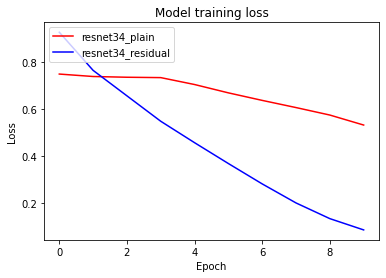

In [121]:
import matplotlib.pyplot as plt

plt.plot(history_resnet34_plain.history['loss'], 'r')
plt.plot(history_resnet_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34_plain', 'resnet34_residual'], loc='upper left')
plt.show()

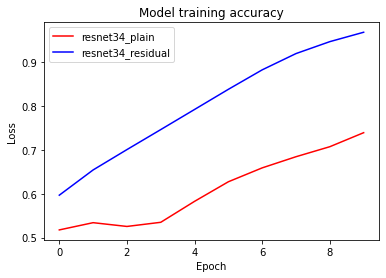

In [130]:
import matplotlib.pyplot as plt

plt.plot(history_resnet34_plain.history['accuracy'], 'r')
plt.plot(history_resnet_34.history['accuracy'], 'b')
plt.title('Model training accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34_plain', 'resnet34_residual'], loc='upper left')
plt.show()

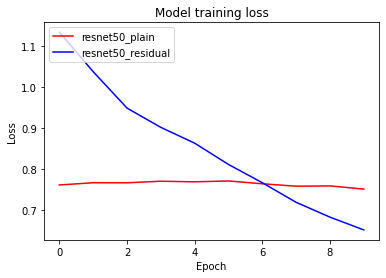

In [127]:
import matplotlib.pyplot as plt

plt.plot(history_resnet50_plain.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50_plain', 'resnet50_residual'], loc='upper left')
plt.show()

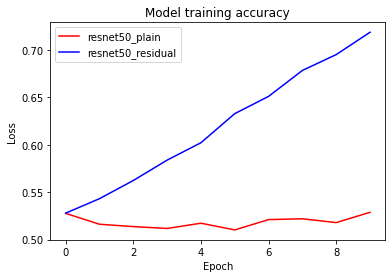

In [129]:
import matplotlib.pyplot as plt

plt.plot(history_resnet50_plain.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.title('Model training accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50_plain', 'resnet50_residual'], loc='upper left')
plt.show()

### goingdeeper 첫 실습으로 cnn의 꽃인 residual를 가미한 resnet을 구현해보았다. 뭔가 이렇게 논문을 구현해보니 어렵기도하지만 성장하는게 느껴진 과제였다. 기본 resnet 모델보다 확실히 어큐러시도 높은것을 보이고있다. 잔차학습이 확실히 도움이 크게된것같다 이것으로 goingdeeper1을 마친다.